In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('..')

import matplotlib.pyplot as plt
from collections import OrderedDict
from sqlalchemy import func, distinct, text, and_
import pandas as pd

import util
from util.year import year
from db import session
import model

In [3]:
users = session.query(model.Year,
                      func.count(distinct(model.User.id))).\
    join(model.Year.tasks).join(model.Task.modules).\
    join(model.Module.submitters).\
    filter(model.User.role == 'participant').\
    group_by(model.Year).all()

for year, points in users:
    print(year.year, points)

2015/2016 218
2016/2017 404
2017/2018 557
2018/2019 755


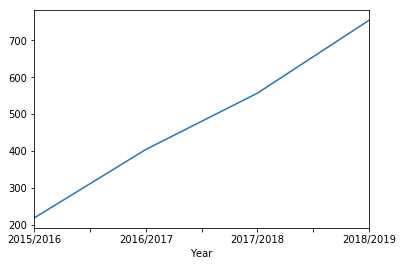

In [4]:
per_module = util.task.points_per_module_all_years().subquery()

per_user = session.query(
    model.Year,
    model.User,
    func.sum(per_module.c.points).label("total_score"),
).\
    join(per_module, model.Year.id == per_module.c.year_id).\
    join(model.User, model.User.id == per_module.c.user_id).\
    filter(model.User.role == 'participant').\
    group_by('year_id', model.User).all()

df = pd.DataFrame(per_user).groupby('Year')
fdf = pd.DataFrame(per_user)
fdf = fdf[fdf['total_score'] > 0].groupby('Year')
per_year = pd.DataFrame(OrderedDict(
    solved_count=df.total_score.count(),
    solved_more_than_0_count=fdf.total_score.count(),
))

per_year.solved_count.plot()